# Tridiagonal Matrix Systems

Tridiagonal matrix systems are common in machine learning, signal processing and control. We saw an example of such systems in the previous tutorial on [total variation denoising](14_total_variation_denoising.ipynb). An $n$-by-$n$ tridiagonal system can be expressed as,

$$
Ax = d
$$

where $A$ has the form

$$
A = \begin{bmatrix}
        b_1 & c_1 & & & 0 \\
        a_2 & b_2 & c_2 & \phantom{\ddots} & 0 \\
		& a_3 & b_3 & \ddots & \\
		& & \ddots & \ddots & c_{n-1} \\
		0 & & & a_{n} & b_n 
\end{bmatrix}
$$

Assuming $A$ is full rank we can obtain the solution $x = A^{-1} d$ using standard techniques such as Gaussian elimination or LU-decomposition. When the matrix $A$ is diagonally dominant or positive definite then faster techniques such as the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm) can be used. However, the Thomas algorithm is iterative so only good for single-threaded hardware or when batch sizes are large (so that each system in the batch can be solved in parallel). A more sophisticated algorithm known as [cyclic reduction](https://en.wikipedia.org/wiki/Cyclic_reduction) can be used to parallelize the solution of tridiagonal systems. This algorithm works by repeatedly eliminating odd and even rows from $A$ resulting in two independent half-size systems that can be solved in parallel.

## Differentiable tridiagonal solvers

Since we can write the solution in closed form, i.e., $x = A^{-1} d$, it is straightforward to derive gradients in the backward pass of a neural network containing tridiagonal systems. Let $v^T = \frac{\text{d} L}{\text{d} x}$ and $w^T = v^T A^{-1}$. Then we have

$$
\begin{align}
\frac{\text{d} L}{\text{d} d} &= w^T \\
\frac{\text{d} L}{\text{d} b} &= -w^T \odot x^T \\
\frac{\text{d} L}{\text{d} a} &= -w_{2:n}^T \odot x_{1:n-1}^T \\
\frac{\text{d} L}{\text{d} c} &= -w_{1:n-1}^T \odot x_{2:n}^T
\end{align}
$$

where the last three expressions can be derived by recognizing that $\frac{\text{d} L}{\text{d} A_{ij}} = -w_i x_j$. Here $\odot$ is the Hadamard (i.e., elementwise) product. We can obtain $w$ by solving $A^T w = v$. Importantly, we can reuse any factorization of $A$ in the forward pass to reduce computational effort in the backward pass, or simply reapply a fast solution method such as the Thomas algorithm or cyclic reduction. Using the latter, the backward pass takes (approximately) the same amount of compute as the forward pass.


In [1]:
%matplotlib inline

import torch
from torch import optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(torch.__version__)
print("device {} will be used".format(device))

2.1.0
device cpu will be used


## Profiling

We will use the example of [total variation denoising](14_total_variation_denoising.ipynb) to profile different implementations of tridiagonal solvers. Note that here we are only profiling the forward pass (since the backward pass for the total variation problem is a pass through operation). Since PyTorch does not provide a native implementation we have written our own version. We compare against the standard linear equation solver (`torch.linalg.solve`) and via Cholesky factorization for different batch and problem sizes.


In [3]:
import time
import sys
sys.path.append("../")

from ddn.pytorch.tridiagsolve import tridiagsolve


def tvsolver(x, lmd, maxiters=100, solver='linalg'):
    """
    Pytorch solver for the 1D total variation denoising problem. Operates on a batch of inputs
    x of size (b, n) all with same lambda. Solver can be 'linalg', 'cholesky', 'tridiagthomas',
    'tridiagcyclic'.
    """

    # initialize u to x
    b, n = x.shape
    u = x.clone()
    
    # iterate
    Dx = (x[:, :-1] - x[:, 1:]).view(b, n - 1, 1)
    neg_ones = -1.0 * torch.ones((b, n - 2), dtype=x.dtype, device=x.device)    
    for _ in range(maxiters):
        L = torch.abs(u[:, :-1] - u[:, 1:]) / lmd
        
        if solver == 'linalg':
            H = torch.diag_embed(L + 2.0) + torch.diag_embed(neg_ones, offset=1) + torch.diag_embed(neg_ones, offset=-1)
            w = torch.linalg.solve(H, Dx)
        elif solver == 'cholesky':
            H = torch.diag_embed(L + 2.0) + torch.diag_embed(neg_ones, offset=1) + torch.diag_embed(neg_ones, offset=-1)
            w = torch.cholesky_solve(Dx, torch.linalg.cholesky(H))
        elif solver == 'tridiagcyclic':
            w = tridiagsolve(L + 2.0, neg_ones, neg_ones, Dx, method='cyclic')
        elif solver == 'tridiagthomas':
            w = tridiagsolve(L + 2.0, neg_ones, neg_ones, Dx, method='thomas')
        else:
            print("Unknown method: {}".format(solver))
            return x
        
        u = x.clone()
        u[:, 1:] += w.view(b, n - 1)
        u[:, :-1] -= w.view(b, n - 1)
        
    return u


# experiment setup
torch.manual_seed(0)
methods = ['linalg', 'cholesky', 'tridiagthomas', 'tridiagcyclic']
exprs = {
    'by_batch' : [(1, 256), (10, 256), (100, 256), (1000, 256)],
    'by_signal_length' : [(1, 64), (1, 128), (1, 256), (1, 512), (1, 1024)]
}

# run experiments
elapsed_time = {k: [[] for j in range(len(exprs[k]))] for k in exprs}
for i, k in enumerate(exprs):
    for j, (b, s) in enumerate(exprs[k]):
        # generate signal
        x = (torch.floor(torch.linspace(-5, 5, s)).view(1, s).repeat(b, 1) + \
            0.5 * torch.randn((b, s), dtype=torch.float32)).to(device)
        
        # find denoised signal
        for m in methods:
            print("profiling '{}' on input of size {}...".format(m, (b, s)), end='\r')
            # profile
            start = time.time()
            u = tvsolver(x, 10.0, 100, m)
            elapsed_time[k][j].append(time.time() - start)

    print(elapsed_time[k])

print("Done.")

[[0.11772680282592773, 0.0585627555847168, 1.4060015678405762, 0.06288456916809082], [0.19827628135681152, 0.20795273780822754, 1.4406285285949707, 0.0788419246673584], [2.039573907852173, 8.213314056396484, 8.262349843978882, 0.5225214958190918], [64.89974451065063, 77.50725793838501, 10.484029293060303, 3.800555467605591]]
[[0.048806190490722656, 0.052315711975097656, 2.187605142593384, 0.28911805152893066], [0.06672954559326172, 0.06759381294250488, 4.157559633255005, 0.3304884433746338], [0.36052608489990234, 0.14142894744873047, 7.294133901596069, 0.3693232536315918], [1.0640439987182617, 0.3024485111236572, 15.11874270439148, 0.4482152462005615], [2.6559839248657227, 0.8785736560821533, 32.047340631484985, 0.44107675552368164]]
Done.


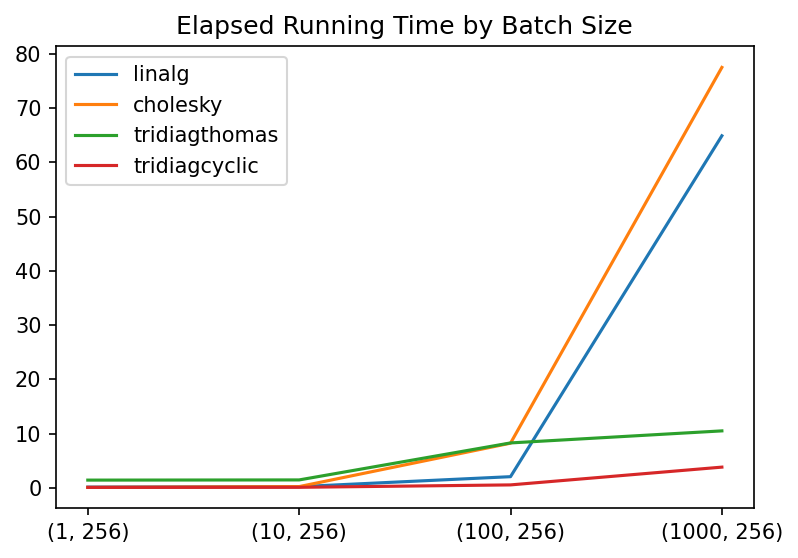

In [4]:
# plot results by batch

plt.figure(figsize=(6, 4), dpi=150)
plt.plot(elapsed_time['by_batch'])
plt.gca().set_xticks(range(len(exprs['by_batch'])))
plt.gca().set_xticklabels(exprs['by_batch'])
plt.title('Elapsed Running Time by Batch Size')
plt.legend(methods)
plt.show()

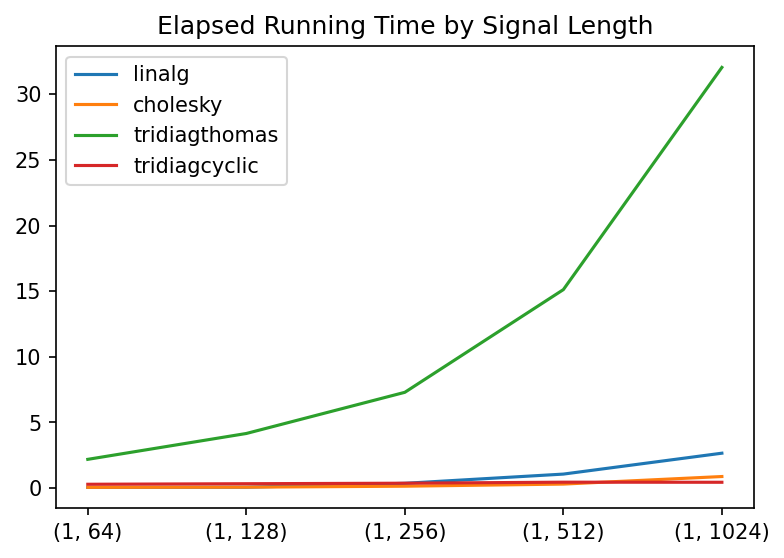

In [5]:
# plot results by signal length

plt.figure(figsize=(6, 4), dpi=150)
plt.plot(elapsed_time['by_signal_length'])
plt.gca().set_xticks(range(len(exprs['by_signal_length'])))
plt.gca().set_xticklabels(exprs['by_signal_length'])
plt.title('Elapsed Running Time by Signal Length')
plt.legend(methods)
plt.show()